# **Exploratory Text Analysis**

## **Topic Introduction & Approach (Thought Process)**

The goal of this project is to conduct an exploratory data and text analysis based on Wikipedia articles. 

The two topics selected to conduct the analysis on are divided into two categories:


*   Programming languages
*   Literary genres

The following appraoch is used: From the Wikipedia articles contained in these two categories, the respective titles and descriptions are extracted via the Wikipedia API. These serve as the data basis for the exploratory analysis. After data collection, the text documents are cleaned and preprocessed with different NLP methods. This is important in order to standardize the data format which should lead to a more efficient data processing. After preprocessing the data, text features are extracted from the data in order to turn the text into numeric data which can be analyzed and compared. The goal is to have several different text features that cover different aspects of the documents in order to get a broad impression of the data.

The analysis is mainly based on assumptions which are checked with regard to the two categories. The goal is to find similarities and differences between the categories as well as examine anomalies and patterns with regard to text features. 

## **Requirements & Configurations**

The required packages are installed and the corresponding libraries are imported as a first step.

In [1]:
# Install relevant libraries
#!pip install wikipedia-api
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_lg
#!pip install scattertext
#!pip install textacy
#!pip install --upgrade spacy
#!pip install markupsafe==2.0.1
#!pip install pyyaml==5.4.1

In [ ]:
# Import relevant libraries 
import wikipediaapi
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import nltk 
from nltk.tokenize import sent_tokenize
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from itertools import chain
from textblob import TextBlob
from pathlib import Path

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import plotly.express as px
from yellowbrick.text.postag import postag

from plotly.offline import iplot
import IPython
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from IPython.display import IFrame

import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')

In [3]:
# Adjust settings for pandas library
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## **Text Extraction**

In this section, documents (article pages) from two different categories are extracted from Wikipedia. Those serve as data sources for the EDA and ETA. 


In [4]:
# Initialize a Wikipedia object and define the language of the documents to be extracted
wiki = wikipediaapi.Wikipedia('en')

### **Category: Programming Languages**

In [5]:
# Define function to extract all documents of the category and corresponding titles and descriptions
def members_collector(category):
      mdict = {}
      categorymembers = category.categorymembers
      for c in categorymembers.values():
        if c.ns == 0:                                                           
          mdict[c.title] = c.summary
      
      return mdict

In [6]:
# Select the category from which the documents are extracted from
pro_languages = wiki.page('Category:Programming_languages')
# Call the function to extract the documents
pro_languages_dict = members_collector(pro_languages)

In [7]:
# Create a dataframe for the extracted documents
pro_languages_df = pd.DataFrame([pro_languages_dict.keys(), pro_languages_dict.values()]).T
# Name the columns in the dataframe
pro_languages_df.columns = ['Title', 'Description']
# Drop the first row by selecting all rows from first row onwards
pro_languages_df = pro_languages_df.iloc[1: , :]

### **Category: Literary Genres**

In [8]:
# Select the category from which the documents are extracted from
literary_genres = wiki.page('Category:Literary_genres')
# Call the function to extract the documents
literary_genres_dict = members_collector(literary_genres)

In [9]:
# Create a dataframe for the extracted documents
literary_genres_df = pd.DataFrame([literary_genres_dict.keys(), literary_genres_dict.values()]).T
# Name the columns in the dataframe
literary_genres_df.columns = ['Title', 'Description']
# Drop the first four rows by selecting all rows from fifth row onwards (index position = 4)
literary_genres_df = literary_genres_df.iloc[4: , :]

### **Dataframe Combination**

In [10]:
# Combine the two dataframes by row
df = pd.concat([pro_languages_df, literary_genres_df], ignore_index=True)

In [11]:
# Display the first two rows of the combined dataframe
df.head(2)

Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description
0                ActionScript                                      ActionScript is an object-oriented programming language originally developed by Macromedia Inc. (later acquired by Adobe Systems). It is influenced by HyperTalk, the scripting language for HyperCard. It is now an implementation of ECMAScript (meaning it is a superset of the syntax and semantics of the language more widely known as JavaScript), though it originally arose as a sibling, both being influenced by HyperTalk.\nActionScript is used primarily for the development of websites and software targeting the Adobe Flash Player platform, used on Web pages in the form of embedded SWF files.\nActionScript 3 is also used with Adobe AIR system for the development of desktop and mobile applications. The language itself is open-source in that its specification is offered free of charge and both an open source compiler (as part of Apache Flex) and open source virtual machine (Mozilla Tamarin) are available.\nActionScript was also used with Scaleform GFx for the development of 3D video game user interfaces and HUDs.
1  Ada (programming language)  Ada is a structured, statically typed, imperative, and object-oriented high-level programming language, extended from Pascal and other languages. It has built-in language support for design by contract (DbC), extremely strong typing, explicit concurrency, tasks, synchronous message passing, protected objects, and non-determinism. Ada improves code safety and maintainability by using the compiler to find errors in favor of runtime errors. Ada is an international technical standard, jointly defined by the International Organization for Standardization (ISO), and the International Electrotechnical Commission (IEC). As of 2020, the standard, called Ada 2012 informally, is ISO/IEC 8652:2012.Ada was originally designed by a team led by French computer scientist Jean Ichbiah of CII Honeywell Bull under contract to the United States Department of Defense (DoD) from 1977 to 1983 to supersede over 450 programming languages used by the DoD at that time. Ada was named after Ada Lovelace (1815–1852), who has been credited as the first computer programmer.

## **Text Cleaning & Preprocessing** 

Next, the data is cleaned and preprocessed to a more easy-to-interpret format. This process is split into four steps.

### **Normalization**

Normalization is performed to clean up the documents and reduce the randomness of natural language. This includes removing unnecessary elements like special characters, whitespaces, line breaks as well as transforming the text to lower-case which makes processing more efficient. 

In [12]:
# Define a function to perform basic normalization tasks
def text_cleaning(doc):
  # Remove special characters (except full stop, question mark and exclamation)
  doc = re.sub(r'[^A-Za-z0-9 \.?!]+', ' ', doc, re.I | re.A)
  # Remove line breaks
  doc = doc.replace('\n', ' ')
  # Remove whitespaces
  doc = doc.strip()
  # Transform to lowercase
  doc = doc.lower()
  return doc
# Call function to perform text cleaning
df['Description'] = df['Description'].apply(lambda x: text_cleaning(x))

Punctuation marks are not removed at this point of the preprocessing. The reason is that those are still used for tokenization on sentence level later on. 

In [13]:
# Clean the titles by truncating unnecessary information from the titles
df['Title'] = df['Title'].apply(lambda x: x.replace('(programming language)', ''))

Since the length of the titles is analyzed as well, unnecessary information is truncated since it artificially prolonges the number of characters and ultimately leads to misrepresentations. In this case, the information *(programming language)* can be left out since all documents are obtained from this category.

### **Tokenization**

The goal of tokenization is to break the documents into smaller units which are mostly lingustically more meaningful as well as are easier to deal with computationally and semantically. Later on, the resulting tokens can be analyzed in a numeric manner. 

Tokenization is performed on two different levels for the descriptions of the obtained documents:


*   Sentences (sentence tokenization)
*   Words (word tokenization)



In [14]:
# Define a function for sentence tokenization
def sentence_tokenization(doc):
  sentence_token_list = []
  for sentence in sent_tokenize(doc):
    sentence_token_list.append(sentence)
  return sentence_token_list
# Call function to perform sentence tokenization
df['Sentence Token'] = df['Description'].apply(lambda x: sentence_tokenization(x))

In [15]:
# Define a function for word tokenization
def word_tokenization(doc):
  word_token_list = []
  for word in word_tokenize(doc):
    word_token_list.append(word)
  return word_token_list
# Call function to perform word tokenization 
df['Word Token'] = df['Description'].apply(lambda x: word_tokenization(x))

In [16]:
# Define function to remove punctuation marks from word token
def remove_punctuation(text):
  for element in text:
    if element == ('.' or '?' or '!'):
      text.remove(element)
  return text
# Call function to perform punctuation removal
df[' Word Token'] = df['Word Token'].apply(lambda x: remove_punctuation(x))

Since punctuation marks also account as word tokens and they have not been removed yet, they are deleted from the word tokens at this point. This in order to include only words as word tokens.

### **Lemmatization**

Lemmatization reduces the surface forms of words to their root forms. This step is done in order to later calculate the TTR of the descriptions with and without lemmatization. Lemmatization hereby is performed directly on the individual word token.

In [17]:
# Define a function for lemmatization
def lemmatization(text):
    nlp = spacy.load('en_core_web_sm', disable=['parse','entity'])
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text   
# Call function to perform lemmatization 
df['Word Token (Lemm)'] = df['Description'].apply(lambda x: lemmatization(x)) 
# Perform word tokenization for lemmatized description
df['Word Token (Lemm)'] = df['Word Token (Lemm)'].apply(lambda x: word_tokenization(x))

In [18]:
# Define function to remove punctuation marks from lemmatized word token
def remove_punctuation(text):
  for element in text:
    if element == ('.' or '?' or '!'):
      text.remove(element)
  return text
# Call function to perform punctuation removal
df['Word Token (Lemm)'] = df['Word Token (Lemm)'].apply(lambda x: remove_punctuation(x))

The assumption is that lemmatization leads to a lower TTR because the number of unique words (types) is reduced overall. Furthermore, the lemmatized TTR gives a deeper insight into lexical diversity since present and past forms of verbs count as one type (since they share the same root) as for example. Therefore, the use of different verb forms would not lead to increased lexical diversity, but the use of synonyms for example would do so (which could potentially be the reason for a high lemmatized TTR).

### **Stop Words Removal**

As a last step within preprocessing, the stop words are removed from the word tokens. With that, only content words carrying a clear meaning on their own are extracted. 

In [19]:
# Define a function to remove stop words
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words
def stop_word_removal(tokens):
  tokens_wo_stops = []
  for token in tokens:
    if token not in stop_words:
      tokens_wo_stops.append(token)
    else:
      continue
  return tokens_wo_stops
# Call function and perform stop word removal
df['Word Token (w/o Stop Words)'] = df['Word Token'].apply(lambda x: stop_word_removal(x))

There are several reasons for the stop word removal. First of all, obtaining word tokens consisting of content words only removes uncesseary noise from the text when it comes to content analysis. Furthermore, the share of stop words within a document can be calculated and later on be analyzed (i.e., the relationship between stop words share and TTR). 



In [20]:
# Display the first two rows of the cleaned and preprocessed text data
df.head(2)

Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Sentence Token                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Word Token                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Word Token                                                                                                                                                                                                                                                                                          

## **Text Features**

In this section, text features of the titles and descriptions are added in order to use them later on for analysis. 

### **Labelling**

As a first step, the titles and descriptions are labelled based on the categories they belong to:


*   Category *Programming Languages* --> Programming
*   Category *Literary Genres* --> Literature

Labelling allows comparisons between the two categories. 

In [21]:
# Add category label in the new column 'Category'
df.loc[df.head(len(pro_languages_df)).index, 'Category'] = 'Programming'
df.loc[df.tail(len(literary_genres_df)).index, 'Category'] = 'Literature'

### **POS Tags**

As a first step, the part-of-speech (POS) tags are assigned to the word token based on their syntactic context and role. Furthermore, the count per tag for every description is calculated. 

Within this work, the POS tags are computed to mainly assess how the different word tokens are distributed across the tag categories (i.e., what categories appear the most and how is their relationship). 

In [22]:
# Define a function to tag POS in word tokens (based on Penn-Treebank norm)
def pos_tagging(tokens):
  tags = nltk.pos_tag(tokens)
  return tags
# Call function to perform POS tagging
df['POS Tags'] = df['Word Token'].apply(lambda x: pos_tagging(x))

In [23]:
# Display the first row of the dataframe to illustrate the result of POS tagging
df.head(1)

Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Sentence Token                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Word Token                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Word Token                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [24]:
# Define a function to count POS tags
def count_pos(tokens):
  tags = nltk.pos_tag(tokens)
  counts = Counter(tag for word, tag in tags)
  return counts
# Call function to count POS tags
df['POS Tag Count'] = df['Word Token'].apply(lambda x: count_pos(x))

### **Count Features**

In this section, different count calculations are performed to add further text features. Count calculations refer to the length of words, sentences or similar (excluded are POS tag counts since that is done already ahead). 

**Title & Description Length**

This count is performed to investigate how text differs between the two categories with regard to number of characters (i.e., which category has longer texts in general). 

Whitespaces are not counted since they artificially increase the count without providing additional information. 

In [25]:
# Define function to get length of the title (w/o whitespaces)
def title_length(title):
  length = len(title) - title.count(" ")
  return length
# Call function and calculate length of titles
df['Title Length'] = df['Title'].apply(lambda x: title_length(x))

In [26]:
# Define function to get length of the description (Penn-Treebank)
def description_length(desc):
  length = len(desc) - (desc.count(' ') + len(re.sub('[^.!?]', '', desc)))
  return length
# Call function and calculate length of descriptions
df['Description Length'] = df['Description'].apply(lambda x: description_length(x))

**Token & Phrases Counts**

At this point, the number of sentence and word tokens are calculated. This information provides insights about whether a text is built upon more or less sentences and whether they carry more or less words on average for example. 

It also serves as starting point to analyze the Type-Token-Ratio (TTR).

In [27]:
# Calculate sentence token count
df['Sentence Token Count'] = df['Sentence Token'].apply(lambda x: len(x))

In [28]:
# Calculate word token count
df['Word Token Count'] = df['Word Token'].apply(lambda x: len(x))

In [29]:
# Define function to calculate the mean of tokens per sentence for every description
def mean_token_per_sentence(text):
  count = 0
  for sentence in text:
    count += len(sentence.split(' '))
  average = count / len(text)
  return round(average, 2)
# Call the function and perform the calculation
df['Mean Token/Sentence'] = df['Sentence Token'].apply(lambda x: mean_token_per_sentence(x))

In [30]:
# Calculate stop words count
df['Stop Words Count'] = df['Word Token'].str.len() - df['Word Token (w/o Stop Words)'].str.len()
# Calculate share of stop words for every description
df['Stop Words Share'] = round(((df['Word Token'].str.len() - df['Word Token (w/o Stop Words)'].str.len())/(df['Word Token'].str.len()))*100, 2)

In addition to the the POS tag counts, the number of noun phrases is counted as well. This process is part of *Chunking* which groups words together to higher-level phrases. Noun phrases have a noun acting as the head word. Their pattern hereby is defined as *Determiner/Adjective/Noun* and is extracted with the help of Regex. 

In [31]:
# Define a function to count number of noun phrases
def count_np(document):
  sentences = nltk.sent_tokenize(document)
  sentences = [nltk.word_tokenize(sent) for sent in sentences]
  sentences = [nltk.pos_tag(sent) for sent in sentences]
  chunks = list(chain.from_iterable(sentences))
  grammar = 'NP: {<DT>?<JJ>?<NN>}'
  cp = nltk.RegexpParser(grammar)
  result = cp.parse(chunks)
  result_string = str(result)
  np_count = result_string.count('NP')
  return np_count
# Call function and perform noun phrases count
df['Noun Phrase Count'] = df['Description'].apply(lambda x: count_np(x))

### **NER**

In this step, Named Entity recognition (NER) is performed to extract the named entities within the documents. NER tags can give valuable insights about the content of a document. It is assumed in this work that named entities may be in relation to features like sentiment polarity (i.e., the number of named entities has an effect on polarity). 

In [32]:
# Create an object using the large English spacy model
nlp = spacy.load("en_core_web_lg")
# Define a function to extract and count NER labels
def get_ner(document):
    ner = [(ent.text.strip(), ent.label_) for ent in nlp(document).ents]
    counts = Counter(tag for word, tag in ner)
    return counts
# Call function and perform NER extraction and label count
df['NER Label Count'] = df['Description'].apply(lambda x: get_ner(x))

In [33]:
# Count total named entities
df['NER Count'] = df['NER Label Count'].apply(lambda x: sum(x.values()))

### **TTR**

The Type-Token-Ratio (TTR) is a measure of lexical diversity. A higher TTR corresponds to an increased set of different words in relation to the total count of words. 

In [34]:
# Define a function to calculate the Type-Token-Ratio (TTR)
def calc_ttr(tokens):
  types = Counter(tokens)
  ttr = (len(types)/len(tokens))*100
  return round(ttr, 2)

# Call function to calculate TTR
df['TTR'] = df['Word Token'].apply(lambda x: calc_ttr(x))
# Call function to calculate TTR for the lemmatized word token
df['TTR (Lemm)'] = df['Word Token (Lemm)'].apply(lambda x: calc_ttr(x))

As already mentioned in a chapter before, the TTR is also calculated for lemmatized tokens since that approach does not take words of the same root into consideration. The use of many synonyms for example could increase the lemmatized TTR.

### **Polarity**

Sentiment polarity is the last text feature to be added to the dataframe. It gives more information about whether a text is written in a positive, negative or neutral sentiment. This information could be later used for classification or augmentation purposes. 

In [35]:
# Calculate polarity
df['Polarity'] = df['Description'].map(lambda text: TextBlob(str(text)).sentiment.polarity)

In [36]:
# Create a dataframe subset for analysis containing only numeric features or features consisting of numeric elements
df_features = df[['Category', 'Title', 'Title Length', 'Description Length', 'Sentence Token Count', 'Word Token Count', 'Mean Token/Sentence', 'TTR', 
                  'TTR (Lemm)', 'Stop Words Count', 'Stop Words Share', 'POS Tag Count', 'Noun Phrase Count', 'NER Label Count', 'NER Count', 'Polarity']]

In [37]:
# Display first two rows of the text features dataframe for illustration
df_features.head(2)

Category         Title  Title Length  Description Length  Sentence Token Count  Word Token Count  Mean Token/Sentence    TTR  TTR (Lemm)  Stop Words Count  Stop Words Share                                                                                                                                                              POS Tag Count  Noun Phrase Count                                                              NER Label Count  NER Count  Polarity
0  Programming  ActionScript            12                 838                     7               162                24.71  59.26       56.79                75             46.30  {'NN': 51, 'VBZ': 8, 'DT': 17, 'VBD': 3, 'JJ': 10, 'RB': 8, 'VBN': 10, 'IN': 26, 'NNP': 1, 'NNS': 8, 'PRP': 5, 'CC': 6, 'RBR': 1, 'VBG': 3, 'VBP': 2, 'CD': 2, 'PRP$': 1}                 53                                      {'ORG': 3, 'PRODUCT': 2, 'CARDINAL': 1}          6  0.139583
1  Programming          Ada              3                 867                     6               159                30.33  70.44       66.67                56             35.22      {'NN': 44, 'VBZ': 6, 'DT': 11, 'JJ': 24, 'RB': 5, 'VBD': 3, 'CC': 5, 'VBN': 11, 'VBG': 3, 'IN': 22, 'NNS': 7, 'PRP': 1, 'TO': 4, 'VB': 2, 'VBP': 1, 'CD': 9, 'WP': 1}                 45  {'ORG': 11, 'DATE': 4, 'NORP': 1, 'PERSON': 2, 'CARDINAL': 1, 'ORDINAL': 1}         20  0.091111

## **Exploratory Data and Text Analysis**

The exploratory analysis is split into two parts - data analysis (EDA) and text analysis (ETA). 

### **Exploratory Data Analysis (EDA)**

Within EDA, the main characteristics of the dataset are summarized in statistical terms. 

In [38]:
# Inspect dimensionality of dataframe
print('Number of rows: ', df_features.shape[0])
print('Number of columns: ', df_features.shape[1])

Number of rows:  349
Number of columns:  16


In [39]:
# Print information about the dataframe
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Category              349 non-null    object 
 1   Title                 349 non-null    object 
 2   Title Length          349 non-null    int64  
 3   Description Length    349 non-null    int64  
 4   Sentence Token Count  349 non-null    int64  
 5   Word Token Count      349 non-null    int64  
 6   Mean Token/Sentence   349 non-null    float64
 7   TTR                   349 non-null    float64
 8   TTR (Lemm)            349 non-null    float64
 9   Stop Words Count      349 non-null    int64  
 10  Stop Words Share      349 non-null    float64
 11  POS Tag Count         349 non-null    object 
 12  Noun Phrase Count     349 non-null    int64  
 13  NER Label Count       349 non-null    object 
 14  NER Count             349 non-null    int64  
 15  Polarity              3

From the information above it is noted that there are no missing values in the features dataframe. Most features are of numeric data type, either integer or float. There are also four features of type 'object'. 

In [40]:
# Compute descriptive statistics of the dataframe
df_features.describe()

Title Length  Description Length  Sentence Token Count  Word Token Count  Mean Token/Sentence         TTR  TTR (Lemm)  Stop Words Count  Stop Words Share  Noun Phrase Count   NER Count    Polarity
count    349.000000          349.000000            349.000000        349.000000           349.000000  349.000000  349.000000        349.000000        349.000000         349.000000  349.000000  349.000000
mean      12.120344          783.512894              5.954155        152.028653            28.510745   67.939026   65.236934         63.521490         41.144069          38.873926    8.346705    0.092410
std        7.599710          575.783842              4.156171        113.622304             9.874145   10.450460   10.990976         49.778679          6.267052          29.551750    9.383442    0.098232
min        1.000000           67.000000              1.000000         13.000000             6.500000   34.180000   29.250000          3.000000         20.370000           2.000000    0.000000   -0.250000
25%        6.000000          364.000000              3.000000         70.000000            21.670000   60.550000   57.740000         29.000000         37.530000          18.000000    2.000000    0.036905
50%       11.000000          622.000000              5.000000        119.000000            27.170000   67.380000   64.340000         50.000000         41.590000          31.000000    6.000000    0.087755
75%       16.000000         1051.000000              8.000000        200.000000            33.000000   74.190000   71.430000         86.000000         45.240000          51.000000   11.000000    0.146259
max       50.000000         3510.000000             25.000000        670.000000            87.670000  100.000000  100.000000        316.000000         58.730000         170.000000   80.000000    0.516667

From the descriptive statistics above can be some interesting information drawn. Over both categories, the average number of words within a sentence is roughly 29, whereby 50% of the descriptions contain less than 27 words per sentence (w/o whitespaces). 

Furthermore, the mean of the lemmatized TTR is a little lower than of the TTR as expected. Since they are not that far away from each other, it can be assumed that lexical diversity does not heavily rely on different forms of the same root word. 

Lastly, sentiment polarity is distributed between -0.25 and 0.51 with a mean of 0.09 which generally speaks for a more or less neutral sentiment with a tendency towards slightly positive sentiment (25% quantile is still positive with 0.03). This comes as expected since Wikipedia articles are of informative nature. 

In [41]:
df_features.describe(include = [object])

Category         Title                                                                                                                                                              POS Tag Count NER Label Count
count          349           349                                                                                                                                                                        349             349
unique           2           349                                                                                                                                                                        349             271
top     Literature  ActionScript  {'NN': 51, 'VBZ': 8, 'DT': 17, 'VBD': 3, 'JJ': 10, 'RB': 8, 'VBN': 10, 'IN': 26, 'NNP': 1, 'NNS': 8, 'PRP': 5, 'CC': 6, 'RBR': 1, 'VBG': 3, 'VBP': 2, 'CD': 2, 'PRP$': 1}              {}
freq           202             1                                                                                                                                                                          1              38

When having a look at the features of type 'object', it can be seen that two categories exist whereby all titles of the documents are unique (no duplicates). What also stands out is the fact that 38 documents do not contain any named entities. 

### **Exploratory Text Analysis (ETA)**

EDA is about exploring the textual aspects of the data and spot patterns and anomalies as well as get deeper insights. 

Within that work, assumptions are made and checked as well as questions are stated and are answered.

**Assumption: \
Literary genre documents have longer titles and descriptions.**

Because of the nature of the topics, it is assumed that documents belonging to the category 'literary genres' have longer titles and descriptions in general. This is based on the perception that literary as a theme is more vivid resulting in more elaborte textual expressions compared to a technological theme such as 'programming languages' which people would probably consider as more formal and dry. 

In [42]:
# Create boxplot to compare the title lengths
fig_box_1 = px.box(df_features, x='Category', y='Title Length', points='all', color='Category',
             title='Title Length by Category')
iplot(fig_box_1)

# Create boxplot to compare the description lengths
fig_box_2 = px.box(df_features, x='Category', y='Description Length', points='all', color='Category',
             title='Description Length by Category')
iplot(fig_box_2)

# Create boxplot to compare the average number of words per sentence
fig_box_3 = px.box(df_features, x='Category', y='Mean Token/Sentence', points='all', color='Category',
             title='Average Number of Words per Sentence by Category')
iplot(fig_box_3)

The stated assumption seems to be applying to the length of titles which are generally longer for the 'literary genres' category. One reason for that might be that programming langues are very often kept short or even are acronyms. 

On the other hand, descriptions for both categories show more or less the same number of characters. This could have been expected since the length of Wikipedia articles does not necessarily depend on the category and is somewhat random (i.e., it is also based on the users' willingness to contribute to a certain article or topic and more general how much is known about it). 

It also can be seen that the average length of sentences is more or less the same for both categories. So not only the descriptions show similarity with regard to length but also the sentences themselves.

**Assumption: \
Longer titles are correlated with longer descriptions.**

This part is based on the assumption that many people probably relate longer words to higher complexity and therefore longer titles to a more elaborate topic requiring a longer description.

In [43]:
# Create scatterplot to inspect relationship between title and description lengths
fig_scatter_1 = px.scatter(df_features, x='Title Length', y='Description Length', color='Category',
                           marginal_x='box', marginal_y='box', trendline='ols', 
                           title='Relationship of Title and Description Length')
iplot(fig_scatter_1)

The data illustrates that there is a positive relation between title and description length for documents of the category 'literay genres'. A reason could be that the titles in this category are tending to be longer and many times, the title is repeated several times within a description which is a self-amplifying effect. In comparison, it is the other way around for the 'programming languages' category showing a negative relation between the two lengths. 

**Assumption:\
Longer sentences as well as a higher number of sentences lead to a lower TTR.**

This assumption is based on a higher probability of word repetitions based on longer and more sentences. In other words, the more words the sentences have and the more are of them, the higher is the chance of repetitions and therefore a lower TTR.

In [44]:
# Create scatter matrix to compare relationships of the mentioned features
fig_scattermatrix_1 = px.scatter_matrix(df_features,
    dimensions=['Mean Token/Sentence', 'Sentence Token Count', 'TTR'],
    color='Category', width=1300, height=650, title='Relationship between Average Sentence Length, Number of Sentences and TTR')
iplot(fig_scattermatrix_1)

The scatter matrix reveals a negative relationship between TTR and both number of sentences (sentence token count) and average number of token per sentence (sentence length). The assumption made seems to be true based on that dataset.

**Assumption: \
Stop Words are negatively correlated with TTR.**

This statement assumes that the occurence of a rather high number of stop words (and an associated higher stop word share therewith) goes along with a lower TTR. The reason for that could be that with applying NLP tools using a predefined set of stop words the chance that one or several stop words repeat themselves increases which ultimately leads to a lower TTR. 


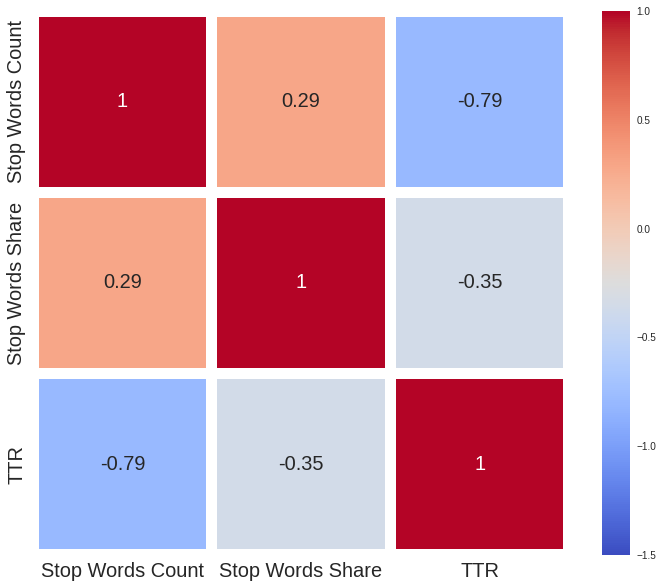

In [45]:
# Create a correlation matrix to visualize the correltion between the mentioned features
correlation = df[['Stop Words Count', 'Stop Words Share', 'TTR']].corr(method='pearson')
mask = np.zeros_like(correlation, dtype=np.bool)
plt.figure(figsize=(12,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 20}, linewidths=10, vmin=-1.5, mask=mask)

Based on the correlation matrix above it can be stated that the number of stop words (stop words count) is negatively correlated with the TTR. This also accounts for the stop words share. By other means, the more stop words a text includes and the higher their share is in relation to the content words (stop words share) the lower the TTR. 

**Assumption: \
Both categories show the same pattern regarding the occurence of the Top5 POS tags.**

With regard to POS, there are one's that occur more frequent than others based on experience (i.e., there are usually more nouns and verbs in a text than determiners and pronouns). This assumption states that the descriptions of both categories show the same pattern regarding the occurence of the POS tags for the five most frequent tags.

In [46]:
# Define function to collect all POS tags for the description of the category 'Programming'
pos_programming = []
def pos_programming_listing(df):
  for ind in df.index:
    tags = df['POS Tags'][ind]
    pos_programming.append(tags)

# Define function to collect all POS tags for the description of the category 'Literature'
pos_literature = []
def pos_literature_listing(df):
  for ind in df.index:
    tags = df['POS Tags'][ind]
    pos_literature.append(tags)

# Call function and create a list for all POS tags in the category 'Programming'
pos_programming_listing(df[df['Category'] == 'Programming'])
# Call function and create a list for all POS tags in the category 'Literature'
pos_literature_listing(df[df['Category'] == 'Literature'])

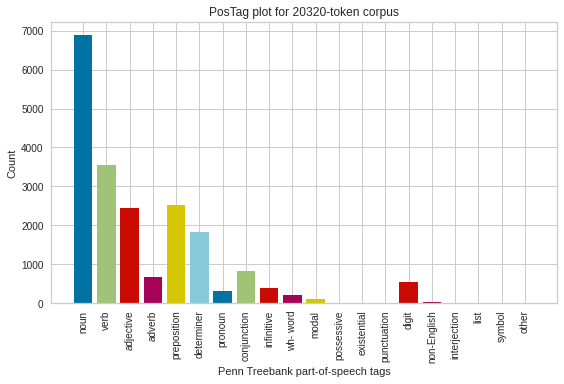

PosTagVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4f84c8210>)

In [47]:
# Visualize the POS tag counts for the category 'Programming'
pos_vis_programming = [pos_programming]
postag(pos_vis_programming)

In [48]:
# Visualize the POS tag counts for the category 'Literature'
pos_vis_literature = [pos_literature]
postag(pos_vis_literature)

PosTagVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4fc6f7a90>)

The two bar charts reveal that ranking of the five most frequent POS tags is pretty much the same for both categories with a slight difference only. 

For both, nouns and verbs occure most frequent (as expected). For the category 'Programming' those two are followed by prepositions, adjectives and determiners. With regard to 'Literature', the ranks of prepositions and adjectives are switched - there are a bit more adjectives than prepositions. 

**Assumption:\
Higher NER count goes along with higher positive or negative polarity**

It is assumed that if text contains more named entities such as persons or organisations, it is written in a more polarizing manner either resulting in more positive or negative sentiment expressions. This is based on the perception that people are probably seduced to write more emotionally when it comes to named entities. 

In [49]:
# Create a jointplot to visualize the relationship of NER count and polarity
trace1 = go.Scatter(
    x=df_features['NER Count'], y=df['Polarity'], mode='markers', name='points',
    marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4)
)
trace2 = go.Histogram2dContour(
    x=df['NER Count'], y=df['Polarity'], name='density', ncontours=20,
    colorscale='Hot', reversescale=True, showscale=False
)
trace3 = go.Histogram(
    x=df['NER Count'], name='NER density',
    marker=dict(color='rgb(102,0,0)'),
    yaxis='y2'
)
trace4 = go.Histogram(
    y=df['Polarity'], name='Polarity density', marker=dict(color='rgb(102,0,0)'),
    xaxis='x2'
)
data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    showlegend=False,
    autosize=False,
    width=1200,
    height=800,
    xaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    margin=dict(
        t=50
    ),
    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='2dhistogram-2d-density-plot-subplots')

It seems that most descriptions are written in a neutral sentiment with polarity around 0. Those descriptions also tend to contain very little named entities. Although there is no clear trend visible, it could be argued that there is a slight positive relationship between the number of named entities and a positive polarity.

**Question: 
\
Which are the most frequent words for both categories?**

As a last step within the ETA, it is analyzed what are the most frequent unigrams (single words are used as observation points) occuring in both categories. The scattertext plot is a suitable approach for that since it visualizes both categories and their respective most frequent unigrams in one plot. 

**Note:** Since only notebooks are allowed to be handed in (and no additional folders, files, etc.) the code to produce the scattertext plot is shown below and its output is inserted as a picture. The code is fully commented out to not get an error while running the whole notebook. 

**Scattertext Plot Code**

In [50]:
# Create a dataframe for the scattertext corpus with the relevant features
#df_scattertext = df[['Category', 'Description']]
# Tokenize the description into word token
#df_scattertext['Content Word Token'] = df_scattertext['Description'].apply(lambda x: nlp(x))
# Convert dataframe into scattertext corpus without stop words
#corpus_wo_stops = st.CorpusFromParsedDocuments(df_scattertext, category_col='Category', 
                                               #parsed_col='Content Word Token').build().remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True)
# Create visualizations for the scattertext corpus                                               
#html_wo_stopwords = st.produce_scattertext_explorer(corpus_wo_stops, category='Programming', 
                                       #category_name='Programming', 
                                       #not_category_name='Literature', 
                                       #minimum_term_frequency=5, 
                                       #term_significance = st.LogOddsRatioUninformativeDirichletPrior())
# Save the visualization in a folder as HTML file
#folder_name = Path('/content/drive/MyDrive/Colab Notebooks/HSLU_CTA/Exercises/Exercise_1') # needs to be adapted to directory
#file_name = folder_name / 'html_wo_stopwords.html'
# Open the HTML file containing the visualization
#open(file_name, 'wb').write(html_wo_stopwords.encode('utf-8'))
# Display the scattertext corpus visualization
#IPython.display.HTML(filename=folder_name / 'html_wo_stopwords.html')

**Scattertext Plot Output**
![picture](https://drive.google.com/uc?id=1ayofjankwXpTVdkh111luye4Ijeyl9CT)


It can be seen that the categories have no overlapping top unigrams - they are different for both categories. Nevertheless, there are some meaningful content words such as 'language' that is common in both categories. The word 'science' would be another example which is present quite often in both. 

That the word 'language' appears very frequently in both categories is not that surprising since programming languages are referred to as formal languages and literature topics are usually incorporate language in general somehow in most times. 

## **Summary**

In this final section, the findings of the EDA and ETA are shortly summarized and discussed as well as the learnings outlined. 

When having a look at the length of text elements such as titles and descriptions, we can see that articles of the category 'Literary genres' tend to have longer titles. This is probably the case since many programming languages are acronyms or kept short in general whereby the titles of literary genres are more descriptive. Apart from that, there is no large difference when it comes to the length of the descriptions or senteces. 

When speaking of sentence tokens, their count as well as their length seem to have a negative effect on the TTR by means of less lexical diversity. A reason for that could be the increased probability of word repetitions. Another feature with a negative influence on TTR are stop words and their shares in proportion to all words. With regard to TTR overall, the TTR of lemmatized texts gives deeper insights into lexical diversity since it only includes the roots of the words. To assess the full lexical diversity of a document, the lemmatized TTR probably would be a helpful additional method to use. 

The last insight to be highlighted is the wrong proven assumption that the number of named entities strongly correlates with sentiment polarity. Just because a document involves more persons, places or organisations does not necessarily mean higher polarity. However, it was detected that texts with a higher count tend to be expressed in a slightly more positive sentiment. 

By solving this project, several learnings were drawn. The first one is how to build a pipeline for text collection and preprocessing in order to be able to analyze the data in an efficient manner (and furthermore use to build machine learning models). With regard to this, it has been noticed that the sequence of the individual preprocessing steps plays an important role. For example, it does not make much sense to remove special characters within the normalization step before sentence word tokenization is performed. In this case, NLP tools tokenize a text into sentences based on punctuation marks which is not possible if they are removed beforehand. In conclusion, the goal of the task for which the preprocessing is performed has to be kept in mind in order to carefully define the sequence of the steps. 

The second learning is the understanding of different text features, how they can be extracted from documents and how they may be playing together. When it comes to their extraction, it has to be kept in mind that different NLP tools can be used for the same purpose (i.e., tokenization). Those tools sometimes work differently and thus lead to varying results. A good illustration for that is word tokenization: The method *word_tokenize* from *nltk.tokenize* does handle a punctuation mark as an own token whereby *TreebankWordTokenizer* appends the punctuation mark to the last word of the respective sentece accounting it as one single token (which ultimately leads to less tokens). What tool is better depends on the use case and how the data is further processed. 

Apart from different methods that can be applied, there also exist different norms or standards. For example when it comes to POS tagging, there is the Penn-Treebank norm (nltk) or the UD norm (spaCy). They mostly differ in the namings of the tags which is relevant in that other functions (i.e., the PosTagVisualizer to count and visualize POS tags only works with the Penn-Treebank tags) may be only working based on one or the other norm.

As a general lesson learned it can be said that there exist many different methods and tools which all have their peculiarities. Hence, when selecting those it is important to keep in mind how they work and what results they produce in order to not get stuck at a later point. 